# Predict KBO

## Predict odds for winning the league of KBO(Korea Baseball Organization)

Based on last 10yrs stats, let's predict the champ team of KBO league

It is  going to be used several classifier with SciKit-Learn     

and predict champs team and qualifiers for playoff.


### Import necessary libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-colorblind')

In [2]:
# import sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### Understanding the data set

In [3]:
# Read Data 
df = pd.read_csv('./data/kbo_data.csv')

In [4]:
df.head(5)

,WIN,POST,YEAR,TEAM,AVG,G,PA,AB,R,H,...,PB,SB_A,CS_A,CS%,SBA,SB,CS,SB%,OOB,PKO.1
0,N,N,2010,넥센,0.262,133,5139,4452,570,1165,...,9,160,68,29.8,191,135,56,70.7,56,5
1,N,Y,2010,두산,0.281,133,5252,4538,731,1276,...,8,119,44,27.0,189,128,61,67.7,56,12
2,N,Y,2010,롯데,0.288,133,5261,4673,773,1345,...,6,131,62,32.1,175,124,51,70.9,62,7
3,N,Y,2010,삼성,0.272,133,5287,4436,681,1207,...,6,134,65,32.7,213,158,55,74.2,54,8
4,N,N,2010,한화,0.244,133,5009,4321,543,1053,...,7,151,58,27.8,191,121,70,63.4,56,11


### Check stats for winning team

Be careful the stat of last 10 years is based on whole season.  

But the stats of this year is coming from in middle of season.  

First, let's use ratio values in the stats.

- AVG : batting AVeraGe 
- OPS : On base Plus Slugging
- RISP : batting AVG at Runner In Scoring Position
- PH-BA : Pinch Hitter - Batting Average
- ERA : Earned Runs Average
- WHIP : Walks Plus Hits Divided by Innings Pitched
- FPCT : Fielding PerCenTage

In [5]:
# features (Ratio values)
# from Batting : AVG, OPS, RISP(Runner In Scoring Position) AVG, PH-BA(Pinch Hitter - Batting Average), 
# from Pitching : ERA, WHIP, 
# from Fielding : FPCT(Fielding PerCenTage)
features = ['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

In [6]:
list(df.loc[df['WIN'] == 1, features])

['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

In [7]:
df.loc[df['WIN'] == 'Y', features].mean()

AVG      0.288889
OPS      0.805778
RISP     0.300111
PH-BA    0.225222
ERA      4.206667
WHIP     1.384444
FPCT     0.984444
dtype: float64

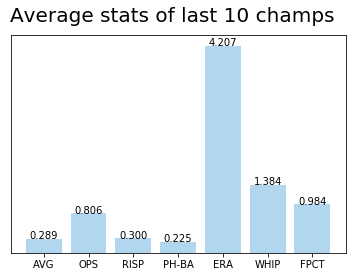

In [8]:
# Draw a chart with matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(features, df.loc[df['WIN'] =='Y', features].mean(), color='#007acc', alpha=.3)
ax.grid(False)
ax.set_yticks([])

fig.suptitle('Average stats of last 10 champs', fontsize=20)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.3f}'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center' )

plt.show()

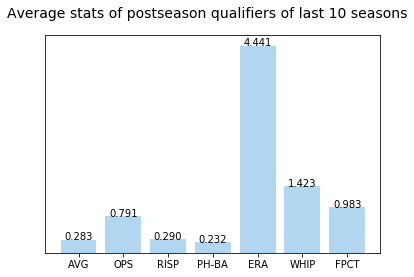

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(features, df.loc[df['POST'] =='Y', features].mean(), color='#007acc', alpha=.3)
ax.grid(False)
ax.set_yticks([])

fig.suptitle('Average stats of postseason qualifiers of last 10 seasons', fontsize=14)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.3f}'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center' )

plt.show()

#### functions for checking the performance of model

In [10]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def print_metrics(labels, preds):
    '''Print score of performance of model'''
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

#### Data Cleaning & Setting

In [11]:
# Cleaning Data for Classifier
df['WIN'] = df['WIN'].map(lambda x: 0 if x == 'N' else 1)
df['POST'] = df['POST'].map(lambda x: 0 if x == 'N' else 1)

In [12]:
# Set target data frames
win_y = df['WIN']
post_y = df['POST']

In [13]:
# Only pick the features with Ratio because it is middle of season
ratio_X = df[['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT', 'CS%', 'SB%']]

In [14]:
# Split data set for train & test model
X_train, X_test, y_train, y_test = train_test_split(ratio_X, win_y, test_size=.2)

#### Training a Model with training data

In [15]:
# Set pipeline with SS & Log_Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', random_state=27))
])

In [16]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=27, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

#### Check Performance of Model

In [17]:
from sklearn.metrics import classification_report

In [18]:
test_preds = pipeline.predict(X_test)

In [19]:
print_metrics(y_test, test_preds)

Precision Score: 1.0
Recall Score: 0.25
Accuracy Score: 0.8235294117647058
F1 Score: 0.4


In [20]:
# Classification Report
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.25      0.40         4

   micro avg       0.82      0.82      0.82        17
   macro avg       0.91      0.62      0.65        17
weighted avg       0.86      0.82      0.78        17



In [21]:
# current(1st of June) stat of KBO leagues 
stat_0601 = {
    'SK': [.251, .702, .282, .289, 3.64, 1.34, .982, 22.2, 75.4],
    'DOOSAN': [.273, .760, .271, .094, 3.13, 1.28, .985, 28.3, 69.0],
    ' LG': [.259, .686, .247, .209, 3.25, 1.26, .984, 16.1, 61.3],
    'NC': [.291, .796, .288, .129, 4.16, 1.38, .980, 45.5, 59.2],
    'KIWOOM': [.285, .776, .308, .237, 4.25, 1.37, .983, 31.0, 70.2],
    'HANWHA':[.253, .701, .259, .119, 4.67, 1.52, .982, 33.3, 74.6],
    'KT': [.270, .715, .267, .200, 4.86, 1.50, .977, 37.9, 69.8],
    'KIA': [.262, .713, .252, .154, 5.06, 1.56, .985, 31.7, 67.3],
    'SAMSUNG': [.266, .739, .256, .292, 4.39, 1.39, .978, 31.5, 75.4],
    'LOTTE': [.269, .718, .271, .224, 5.87, 1.70, .978, 32.2, 70.0],
}

In [22]:
for team, value in stat_0601.items():
    print(f'{team} :  {pipeline.predict_proba([value])[0][1]*100:.4}%')

SK :  0.7814%
DOOSAN :  87.44%
 LG :  1.358%
NC :  19.19%
KIWOOM :  18.16%
HANWHA :  1.273%
KT :  0.06087%
KIA :  0.5576%
SAMSUNG :  0.0477%
LOTTE :  0.005746%


#### Training a model with whole data

Because of small amount of data, let's try training a model with whole data

In [23]:
# re Train model with whole dataset
pipeline.fit(ratio_X, win_y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=27, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [24]:
test_preds = pipeline.predict(X_test)

In [25]:
print_metrics(y_test, test_preds)

Precision Score: 1.0
Recall Score: 0.5
Accuracy Score: 0.8823529411764706
F1 Score: 0.6666666666666666


In [26]:
# Classification Report
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.50      0.67         4

   micro avg       0.88      0.88      0.88        17
   macro avg       0.93      0.75      0.80        17
weighted avg       0.90      0.88      0.87        17



In [27]:
predicts = {}
for team, value in stat_0601.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  0.858%
DOOSAN :  89.14%
 LG :  0.7194%
NC :  38.34%
KIWOOM :  30.51%
HANWHA :  0.4719%
KT :  0.04692%
KIA :  0.1473%
SAMSUNG :  0.04548%
LOTTE :  0.001638%


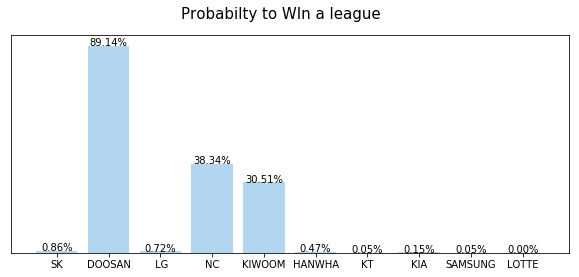

In [28]:
# Draw a chart
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(predicts.keys(), predicts.values(), color='#007acc', alpha=.3)
ax.grid(False)
ax.set_yticks([])

fig.suptitle('Probabilty to WIn a league', fontsize=15)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.2f}%'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center' )

plt.show()

### Predict a odds for Playoff

In [29]:
X_train, X_test, y_train, y_test = train_test_split(ratio_X, post_y, test_size=.2)

In [30]:
# Set pipeline with SS & Log_Regressor
pipeline_post = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', random_state=27))
])

In [31]:
pipeline_post.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=27, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [32]:
test_preds = pipeline_post.predict(X_test)

In [33]:
print_metrics(y_test, test_preds)

Precision Score: 0.7
Recall Score: 0.7777777777777778
Accuracy Score: 0.7058823529411765
F1 Score: 0.7368421052631577


In [34]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.70      0.78      0.74         9

   micro avg       0.71      0.71      0.71        17
   macro avg       0.71      0.70      0.70        17
weighted avg       0.71      0.71      0.70        17



In [35]:
predicts = {}
for team, value in stat_0601.items():
    proba = pipeline_post.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  92.12%
DOOSAN :  99.65%
 LG :  97.28%
NC :  82.34%
KIWOOM :  98.09%
HANWHA :  0.9459%
KT :  0.6318%
KIA :  0.8934%
SAMSUNG :  16.78%
LOTTE :  0.02128%


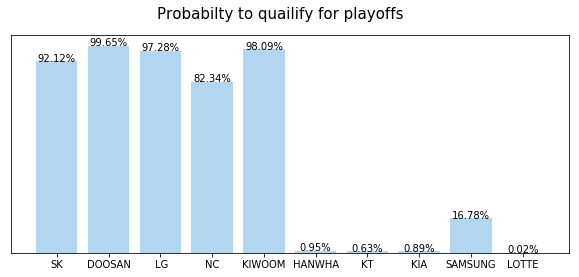

In [36]:
# Draw a chart
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(predicts.keys(), predicts.values(), color='#007acc', alpha=.3)
ax.grid(False)
ax.set_yticks([])

fig.suptitle('Probabilty to quailify for playoffs', fontsize=15)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.2f}%'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center' )

plt.show()

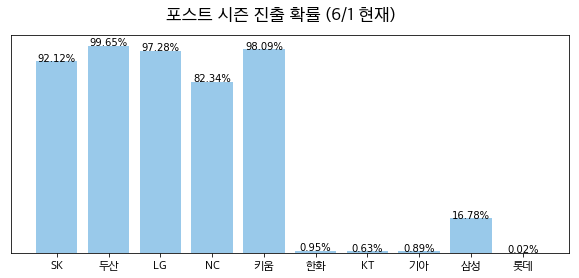

In [37]:
# Draw a chart in Korean
teams = ['SK', '두산', 'LG', 'NC', '키움', '한화', 'KT', '기아', '삼성', '롯데']

title_font = fm.FontProperties(fname='/System/Library/Fonts/AppleSDGothicNeo.ttc', size=18)
label_font = fm.FontProperties(fname='/System/Library/Fonts/AppleSDGothicNeo.ttc', size=12)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(teams, predicts.values(), color='#007acc', alpha=.4)
ax.set_xticklabels(teams, fontproperties=label_font)
ax.grid(False)
ax.set_yticks([])

fig.suptitle('포스트 시즌 진출 확률 (6/1 현재)', fontproperties=title_font)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.2f}%'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center' )


plt.savefig('post_korean.png')
plt.show()

### Another prediction at 6/30

In [38]:
# current(30th of June) stat of KBO leagues 
#['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT', 'CS%', 'SB%']

stat_0630 = {
    'SK': [.267, .734, .285, .262, 3.52, 1.31, .984, 26.4, 69.0],
    'DOOSAN': [.273, .747, .269, .133, 3.46, 1.33, .985, 23.2, 72.6],
    'KIWOOM': [.281, .768, .292, .240, 4.05, 1.35, .981, 34.9, 75.9],
    ' LG': [.262, .695, .250, .229, 3.50, 1.34, .982, 18.2, 68.1],
    'NC': [.281, .766, .280, .153, 4.45, 1.43, .980, 42.4, 59.1],
    'KT': [.274, .720, .270, .220, 4.72, 1.46, .979, 38.8, 67.1],
    'SAMSUNG': [.269, .752, .265, .234, 4.50, 1.42, .980, 29.7, 75.0],
    'KIA': [.265, .717, .254, .186, 4.99, 1.54, .983, 29.3, 67.5],
    'HANWHA':[.252, .695, .255, .130, 4.73, 1.52, .980, 33.3, 73.2],
    'LOTTE': [.262, .702, .266, .232, 5.10, 1.61, .979, 33.7, 67.7],
}

In [39]:
new_predicts_to_win = {}
for team, value in stat_0630.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    new_predicts_to_win[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  10.3%
DOOSAN :  53.64%
KIWOOM :  18.41%
 LG :  0.3017%
NC :  3.668%
KT :  0.1391%
SAMSUNG :  0.3437%
KIA :  0.06064%
HANWHA :  0.1044%
LOTTE :  0.006309%


In [40]:
new_predicts = {}
for team, value in stat_0630.items():
    proba = pipeline_post.predict_proba([value])[0][1]*100
    new_predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  98.94%
DOOSAN :  98.84%
KIWOOM :  93.23%
 LG :  86.62%
NC :  32.04%
KT :  3.002%
SAMSUNG :  30.19%
KIA :  1.556%
HANWHA :  0.3803%
LOTTE :  0.1783%


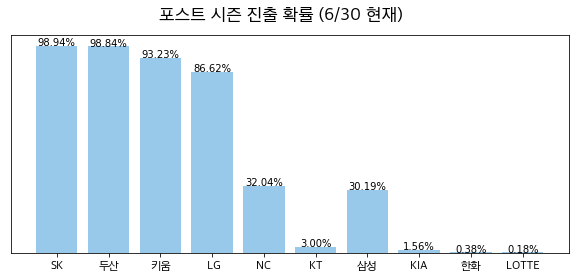

In [41]:
# Draw a chart in Korean
teams = [team for team, value in stat_0630.items()]

teams[1] = '두산'
teams[2] = '키움'
teams[6] = '삼성'
teams[8] = '한화'
title_font = fm.FontProperties(fname='/System/Library/Fonts/AppleSDGothicNeo.ttc', size=18)
label_font = fm.FontProperties(fname='/System/Library/Fonts/AppleSDGothicNeo.ttc', size=12)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(teams, new_predicts.values(), color='#007acc', alpha=.4)

ax.set_xticklabels(teams, fontproperties=label_font)
ax.grid(False)
ax.set_yticks([])

fig.suptitle('포스트 시즌 진출 확률 (6/30 현재)', fontproperties=title_font)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.2f}%'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center' )

plt.savefig('post_korean_0630.png')
plt.show()

### Conclusion

Even though SK is leading the league, Doosan, Kiwoom, NC are looking powerful teams of stats.  
Let's see what is happening on this September!!!

#### One more thing

### use more classification methods

- RandomForest Model
- XGBoost
- SVM


#### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
X_train, X_test, y_train, y_test = train_test_split(ratio_X, post_y, test_size=.2)

In [57]:
# Set pipeline with SS & RandomForest
pipeline_rfc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=20, random_state=27))
])

In [58]:
pipeline_rfc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None...mators=20, n_jobs=None,
            oob_score=False, random_state=27, verbose=0, warm_start=False))])

In [59]:
test_preds = pipeline_rfc.predict(X_test)

In [60]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         9

   micro avg       1.00      1.00      1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [61]:
new_predicts = {}
for team, value in stat_0630.items():
    proba = pipeline_rfc.predict_proba([value])[0][1]*100
    new_predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  90.0%
DOOSAN :  75.0%
KIWOOM :  80.0%
 LG :  55.0%
NC :  55.0%
KT :  40.0%
SAMSUNG :  30.0%
KIA :  10.0%
HANWHA :  10.0%
LOTTE :  15.0%


#### SVM (Support Vector Machines)

In [70]:
from sklearn.svm import SVC

In [71]:
X_train, X_test, y_train, y_test = train_test_split(ratio_X, post_y, test_size=.2)

In [94]:
# Set pipeline with SS & SVC
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=27))
])

In [95]:
pipeline_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=27,
  shrinking=True, tol=0.001, verbose=False))])

In [96]:
test_preds = pipeline_svc.predict(X_test)

In [97]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.80      0.89      0.84         9

   micro avg       0.82      0.82      0.82        17
   macro avg       0.83      0.82      0.82        17
weighted avg       0.83      0.82      0.82        17



In [98]:
new_predicts = {}
for team, value in stat_0630.items():
    proba = pipeline_svc.predict_proba([value])[0][1]*100
    new_predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

SK :  91.88%
DOOSAN :  91.07%
KIWOOM :  90.95%
 LG :  19.53%
NC :  81.56%
KT :  9.786%
SAMSUNG :  17.58%
KIA :  1.43%
HANWHA :  1.423%
LOTTE :  0.5314%
